In [1]:
!rm -rf images/_cylinders

# Imports

In [2]:
from PIL import Image, ImageDraw

Pytroch:

In [3]:
import torch
from torch import nn
import torchvision.transforms as transforms

Numpy and charts

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import timeit
from datetime import timedelta
import sys
import random
from typing import List, Tuple
import timeit

We will keep variables inside an object to not pollute the global namespace, and prevent various bugs. The class defined as follows allows adding attributes at runtime:

In [5]:
class Object(object):
    pass

# Will contain all our variables
t = Object()

# Prepare - Generate Cylinder Images

The code below generates cylinder images that we will use for training. We don't use this code directly anywhere else. You can pre-generate images, save them, and use the training part separately.

In [6]:
class ImageContainer:
    def __init__(self, image: Image, wh: Tuple[int, int]):
        self.image = image
        self.wh = wh
        
    def save_to_dir(self, image_dir, image_index):
        w, h = self.wh
        save_path = f"{image_dir}/image_{image_index}_{w}_{h}.png"
        self.image.save(save_path, cmap="gray")
        
    def get_image(self) -> Image:
        return self.image
  
def draw_cylinder(wh: tuple, image_size) -> ImageContainer: 
    w, h = wh
    background_color = 0
    figure_color = 200
    line_thickness = 2
    ellipse_h = 10 # int(min(image_size / 6, h / 3))
    im = Image.new("L", (image_size, image_size))
    
    draw = ImageDraw.Draw(im)
    draw.rectangle([0, 0, im.size[0], im.size[1]], 
                   fill=background_color,
                   outline=figure_color)
    
    # Calculate offsets when drawing a bounding rectangle
    im_w, im_h = im.size 
    x_offset = (im_w - w) / 2
    y_offset = (im_h - h) / 2

    # Sides
    draw.line([x_offset, y_offset, x_offset, y_offset + h], width=line_thickness, fill=figure_color)
    draw.line([x_offset + w, y_offset, x_offset + w, y_offset + h], width=line_thickness, fill=figure_color)
    
    
    # top ellipse
    draw.ellipse([
        x_offset, 
        y_offset - ellipse_h / 2,
        x_offset + w,
        y_offset + ellipse_h / 2], 
        width=line_thickness,
        outline=figure_color)
    
    # bottom ellipse
    draw.ellipse([
        x_offset, 
        y_offset - ellipse_h / 2 + h,
        x_offset + w,
        y_offset + ellipse_h / 2 + h], 
        width=line_thickness,
        outline=figure_color)
    
    # hide the back side of the bottom ellipse
    draw.rectangle([
        x_offset + line_thickness , 
        y_offset - ellipse_h / 2 + h,
        x_offset + w - line_thickness + 1,
        y_offset + h], 
        fill=background_color, 
        width=line_thickness)
    
    return ImageContainer(im, wh)
#------------------------------------------------------------------------------------
def generate_cylinders(count, w_range, h_range, image_size) -> List[ImageContainer]:
    images = []
    for w in range(w_range[0], w_range[1] + 1):
        for h in range(h_range[0], h_range[1] + 1):
            images.append(draw_cylinder((w, h), image_size))
    random.shuffle(images)
    return images[0:count]
#------------------------------------------------------------------------------------
def save_images(output_folder, images):
    for i, img in enumerate(images):
        img.save_to_dir(output_folder, i)
#------------------------------------------------------------------------------------
t.image_size = 64
dirs = "images/_cylinders"
os.makedirs(dirs, exist_ok=True)
min_size = 14
max_size = 50
images = generate_cylinders(1000, (min_size, max_size), (min_size, max_size), t.image_size)
save_images("images/_cylinders", images)

# Main part 

## Create Device, GPU or CPU

In [7]:
t.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t.device

device(type='cuda')

## Pytorch Tensors

`ToTensor` is a function from the `transforms` package that converts numpy arrays to Pytorch Tensors. During the conversion it performs a few operations:

1. Changes order of dimensions from numpy's Height x Width x Channel to C x H x W.
2. Rescales [0, 255] to [0.0, 1.0]

In [8]:
t.to_tensor = transforms.ToTensor()

## Read Images

Location of our images (see the code above to find out this location):

In [9]:
t.image_folder = "images/_cylinders"

In [10]:
def read_images(folder):
    images = []
    image_tensors = []
    for fname in os.listdir(folder):
        image_path = f"{folder}/{fname}"
        im = Image.open(image_path).convert("L")
        np_im = np.asarray(im)
        images.append(np_im)
    return np.asarray(images)

In [11]:
t.images = read_images(t.image_folder)
t.images.shape

(1000, 64, 64)

We'll this function to display our images.

In [12]:
def plot_images(images):
    fig, axis = plt.subplots(1, len(images), figsize=(20, 5))
    for i, img in enumerate(images):
        ax = axis[i]
        ax.axis('off')
        ax.imshow(img, cmap="gray")

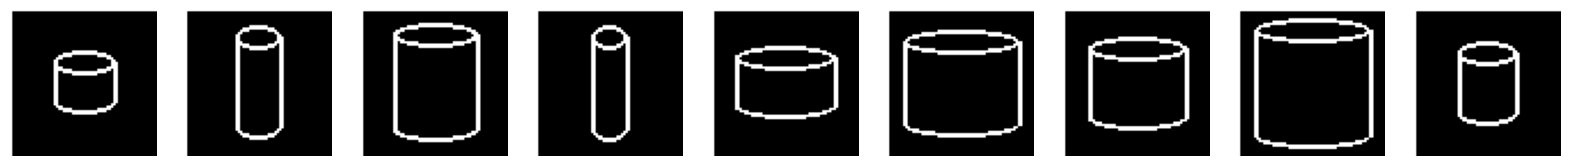

In [13]:
plot_images(t.images[11:20])

## Convert Images to Tensors

In [14]:
def image_np_to_tensor(images_np, to_tensor):
    images_t = torch.zeros(images_np.shape[0], 1, images_np.shape[1], images_np.shape[2])
    for i in range(images_np.shape[0]):
        images_t[i] = to_tensor(images_np[i])
    return images_t

In [15]:
t.images_t = image_np_to_tensor(t.images, t.to_tensor).to(t.device)
t.images_t.shape

torch.Size([1000, 1, 64, 64])

# Design Model

Pytorch doesn't provide a "reshape" layer that we will need for our model. They didn't provide "Flatten" for a while either, but then added it. The hope is they will add Reshape at some point as well.

For now, we'll just implement. All NN layers inherit from nn.Module.

In [16]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

## Model 

In [17]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self._total_epochs = 0
        self._training_time_s = 0
        self._timer = None
        
        self.encoder = nn.Sequential(
        #     # C2: 1 ch, 64 x 64 
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
        #     # C2: 1 ch, 32 x 32 
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
        #     # C3: 16 x 16
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
        #     # C3: 8 x 8
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
        #     # C4: 4 x 4            
            nn.Flatten(),    
            nn.Linear(64 * 4 * 4, 2),
        ).to(t.device)
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 64 * 4 * 4),
            Reshape(-1, 64, 4, 4),
            # 4 x 4
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 8 x 8 
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 16 x 16
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # # 32 x 32
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),  
            # 64 x 64
            nn.Sigmoid(),
        ).to(t.device)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def start_training(self): 
        if not self._timer:
            self._timer = timeit.default_timer()
    
    def end_training(self):
        self._training_time_s += timeit.default_timer() - self._timer
        self._timer = None
        
    def add_epochs(self, epochs):
        self._total_epochs += epochs
        
    def total_epochs(self):
        return self._total_epochs
    
    def training_timedelta(self) -> timedelta:
        return timedelta(seconds=self._training_time_s)

t.model = AE()

### Trainable Parameters

In [18]:
print('Trainable parameters:', sum(p.numel() for p in t.model.parameters() if p.requires_grad))

Trainable parameters: 139811


## Plot input and output images before training

### Input

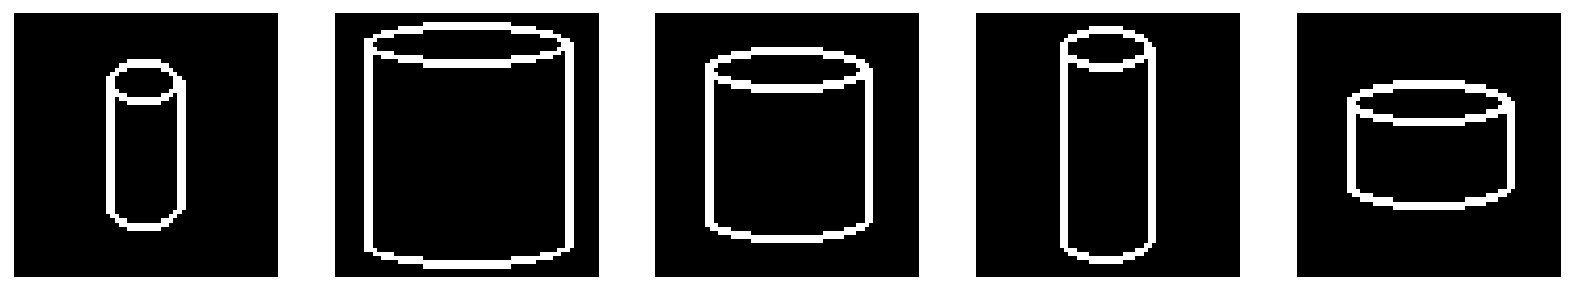

In [19]:
i = 100
plot_images(t.images[i:i+5])

What would output, that is, decoded images will look like now, before we did no training of the network?

Let's pass images through the network, that is:

```
Input Image -> Encoder -> (0.1, -2.3) -> Decoder -> Output Image
```

Execute the model, both encoder and decoder:

In [20]:
imgs = t.model(t.images_t[i: i+5])

Show output images

In [21]:
# Move images to CPU
imgs = imgs.cpu()

# Disconnect from training data structures, 
# or Pytorch will complain during the conversion to numpy
imgs = imgs.detach()

# Conver to Numpy
imgs = imgs.numpy()

imgs.shape

(5, 1, 64, 64)

We need to get rid of an extra dimension, "1". Pytorch requires, but our drawing functions won't work:

In [22]:
imgs = np.squeeze(imgs, axis=1)
imgs.shape

(5, 64, 64)

What do you expect output images to look like now? To test your intiuition, try to imagine the result, then run the following line.

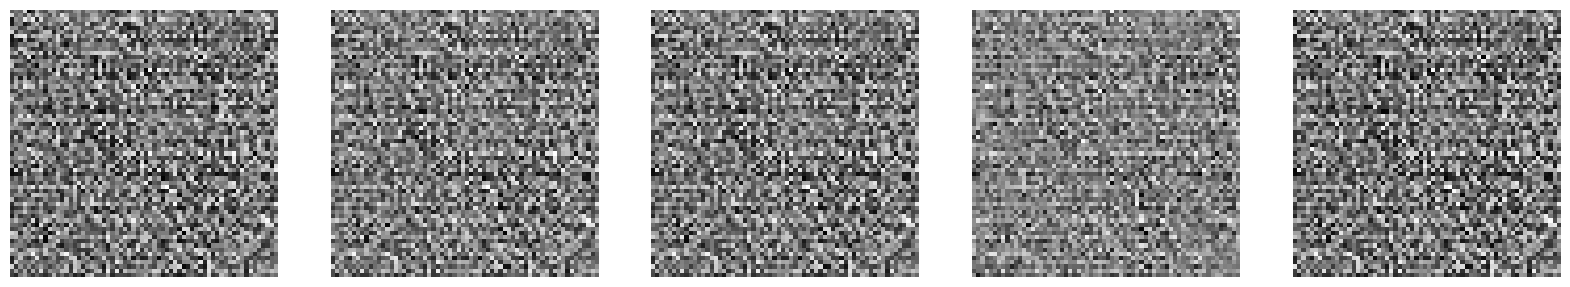

In [23]:
plot_images(imgs)

# Training Loop

In [24]:
def train(model, n_epochs, train_images, opt, criterion, report_each_nth_epoch):
    batch_size = 16
    for epoch in range(1, n_epochs + 1):
        if model.total_epochs() >= n_epochs:
            break
        model.start_training()
        batch_count = int(train_images.shape[0] / batch_size) + 1
        for i in range(0, batch_count):
            start_i = i * batch_size
            image_batch = train_images[start_i : start_i + batch_size]
            if image_batch.shape[0] > 0:
                output = model(image_batch)
                loss = criterion(output, image_batch)
                model.zero_grad()
                loss.backward()
                opt.step()
        model.add_epochs(1)
        if epoch % report_each_nth_epoch == 0:
            model.end_training()
            avg_error = loss.item()
            print(f" Epoch {epoch}",
                  f"\n Train loss: {avg_error}",
                  f"\n Total epochs: {model._total_epochs}",
                  f"\n Total training time: {model.training_timedelta()}")

## Training Algorithm and the Loss Function

In [27]:
t.mse_loss_base = nn.MSELoss(reduction="none")

def mse_loss(pred, y_true):
    pixel_loss = t.mse_loss_base(pred, y_true)
    batch_size = y_true.shape[0]
    pixel_loss_sum = pixel_loss.view(batch_size, -1).sum(axis=1) # sum over pixels
    loss = pixel_loss_sum.mean() # Mean over the batch
    return loss

t.criterion = mse_loss
t.opt = torch.optim.Adam(t.model.parameters(), lr=1e-5)

## Training... 

In [46]:
train(t.model, 2300, t.images_t, t.opt, t.criterion, 50)

 Epoch 50 
 Train loss: 12.17283821105957 
 Total epochs: 2269 
 Total training time: 0:28:50.295204


# See Results

## Plot original images

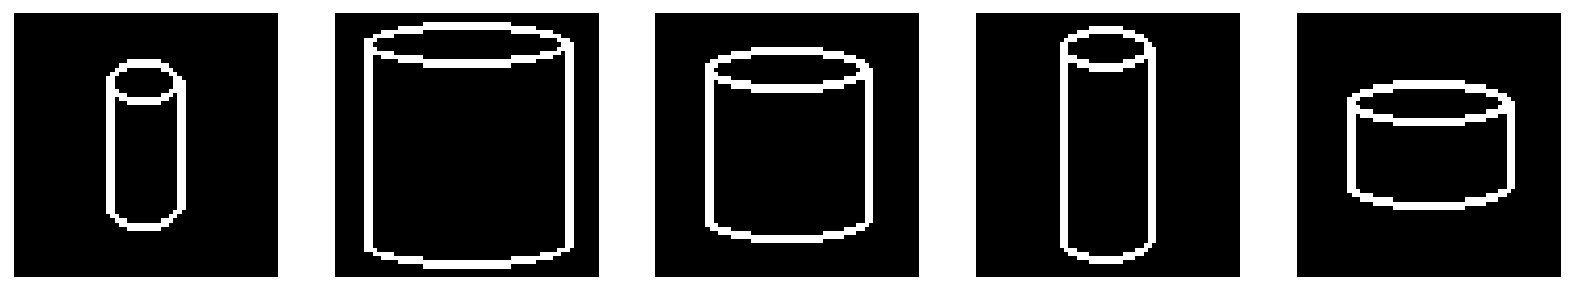

In [30]:
i = 100
plot_images(t.images[i:i+5])

## Plot output images

Using the same method as above, only collected into a single line:

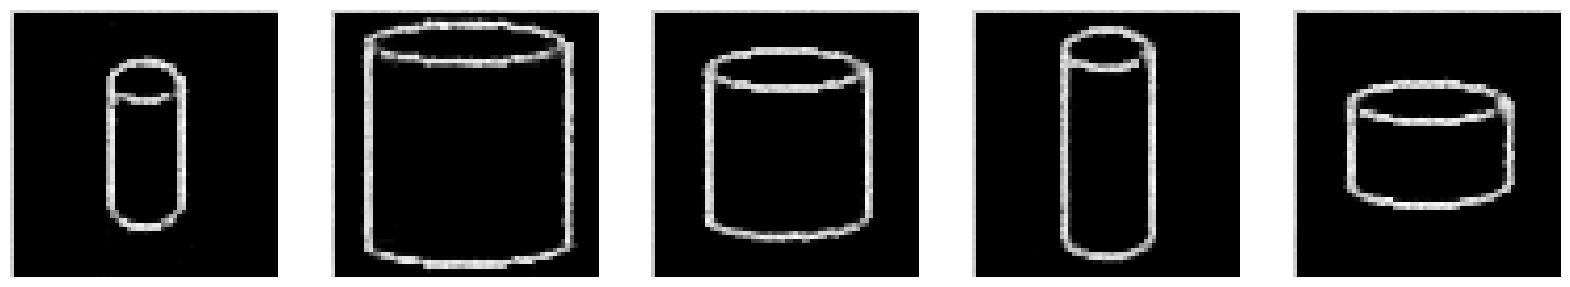

In [31]:
# Pass source images through the network, i.e. x_hat = Decoder(Encoder(x))
imgs = t.model(t.images_t[i: i+5])

# Convert to numpy and plot
plot_images(np.squeeze(imgs.cpu().detach().numpy()))

In [32]:
t.model.encoder(t.images_t[0: 5])

tensor([[ 2.7532,  3.2743],
        [-0.2040, -0.8940],
        [ 2.1910,  2.8426],
        [ 4.3150,  2.5235],
        [ 1.6371,  0.5199]], device='cuda:0', grad_fn=<AddmmBackward>)

# Save the Model

Just in case

In [33]:
torch.save(t.model, 'cylinder_autoencoder.pkl')

# Analyze the Autoencoder

Pass all images through the Encoder, and plot the points in teh 2-D latent space.

Optionally, load the model from the file if you pre-trained it prevously. Otherwise, use current results.

## 1. Load model from file

In [34]:
# Load from file 


# a = Object()
# a.model = torch.load('../input/model123/model.pkl', map_location=t.device)
# _ = a.model.eval()
# _ = a.model.encoder.eval()

## 2. Or, Use Current Training

In [35]:
a = t

## 3. Pass All Images Through the Encoder Only

In [36]:
# Pass through model
a.output = a.model.encoder(t.images_t)

# Convert to numpy
a.emb = a.output.cpu().detach().numpy()

**Q1. What would be the output of the Encoder?**

**Q2. What is the shape of the output?**


In [37]:
a.emb[0:10]

array([[ 2.725043  ,  3.201056  ],
       [-0.24322392, -0.8622546 ],
       [ 2.1477833 ,  2.7908888 ],
       [ 4.313387  ,  2.4580472 ],
       [ 1.6336691 ,  0.531788  ],
       [ 7.6095448 , -0.19864799],
       [ 2.722092  ,  3.442522  ],
       [ 5.683911  ,  2.2581203 ],
       [ 0.6257164 ,  4.634652  ],
       [ 6.0026574 ,  1.1949085 ]], dtype=float32)

In [38]:
a.emb.shape

(1000, 2)

## 4. Plot All Embeddings

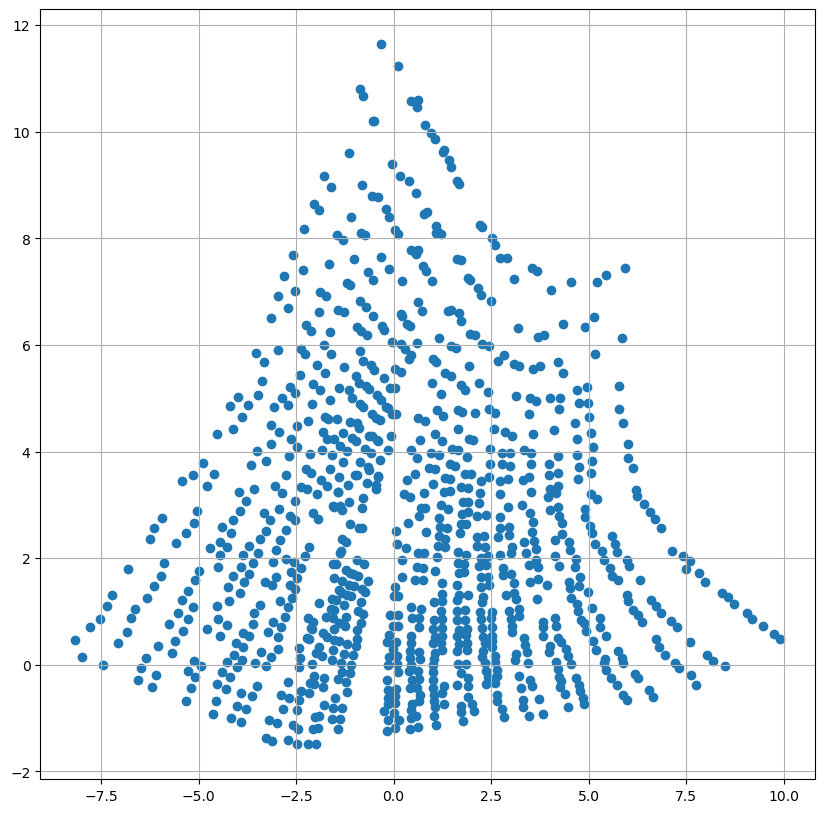

In [39]:
plt.figure(figsize=(10, 10))
plt.grid()
plt.scatter(a.emb[:,0], a.emb[:,1])

In [40]:
def dream_cylinder(x, y):
    plt.imshow(
        a.model.decoder(torch.tensor([x*1.0, y]).to(t.device)).detach().cpu().numpy()[0][0],
        cmap="gray")

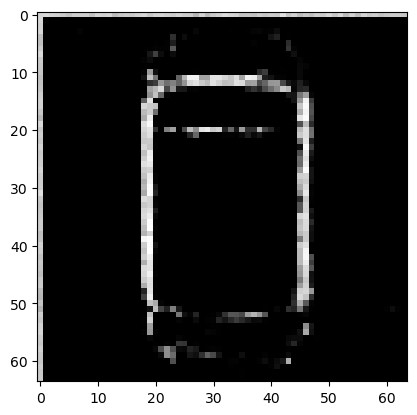

In [42]:
dream_cylinder(0, 3)

# Visualize Embedding Space

In [43]:
def plot_embedding_space(
    model: AE,
    x_range: Tuple[int], 
    y_range: Tuple[int], 
    wh: Tuple[int], 
    n: int):
    w = wh[0]
    big_img = np.zeros((w * n, w * n))
    xs = np.linspace(x_range[0], x_range[1], n)
    ys = np.linspace(y_range[0], y_range[1], n)
    for i, y in enumerate(ys):
        for j, x in enumerate(xs):
            z = torch.Tensor([[x, y]]).to(t.device)
            input_hat = model.decoder(z) \
                .reshape(w, w) \
                .to('cpu') \
                .detach() \
                .numpy()
            big_img[(n - 1 - i) * w : (n - 1 - i + 1) * w,
                j * w : (j + 1) * w] = input_hat
    plt.figure(figsize=(15, 15))
    plt.imshow(big_img, extent=[*x_range, *y_range], cmap="gray")

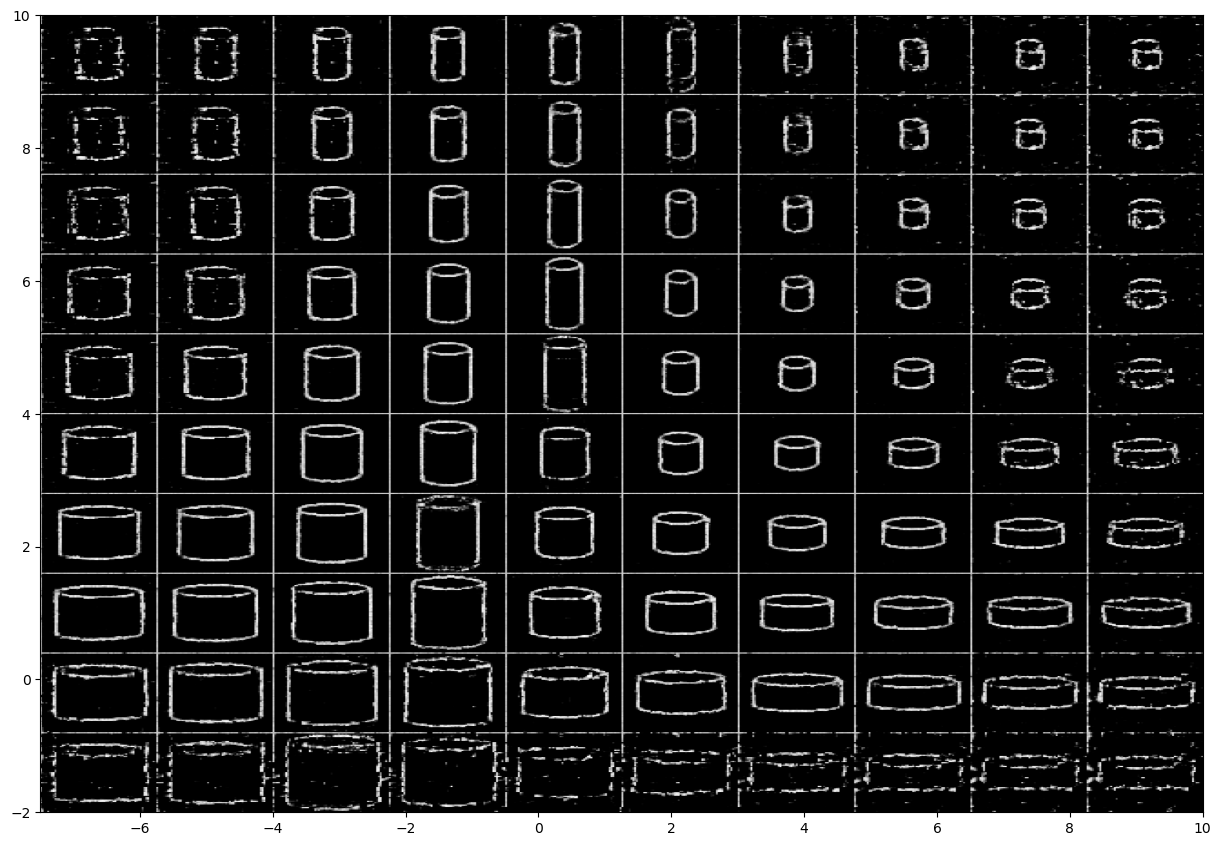

In [44]:
# t.x_range = (a.emb[:,0].min(), a.emb[:,0].max())
# t.y_range = (a.emb[:,1].min(), a.emb[:,1].max())

plot_embedding_space(t.model, 
                     x_range=(-7.5, 10), 
                     y_range=(-2, 10), 
                     wh=(64, 64),
                     n=10)